In [1]:
from src.load_data import get_data
from src.EchoGAE import EchoGAE_algorithm

/home/faisal/miniconda3/envs/topics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasets = ["gun", "abortion", "super_bowl", "sxsw"]
ds = datasets[0]

# Echo Chamber Score:

In [3]:
G, users_embeddings, labels, allsides_scores, node_id_map = get_data(f"data/{ds}/")

In [4]:
user_emb = EchoGAE_algorithm(G, user_embeddings= users_embeddings,show_progress=True, hidden_channels = 20, out_channels=10, epochs=300)

Epoch: 001, AUC: 0.8910, AP: 0.8733
Epoch: 002, AUC: 0.8929, AP: 0.8743
Epoch: 003, AUC: 0.8933, AP: 0.8745
Epoch: 004, AUC: 0.8941, AP: 0.8749
Epoch: 005, AUC: 0.8965, AP: 0.8762
Epoch: 006, AUC: 0.8989, AP: 0.8773
Epoch: 007, AUC: 0.9014, AP: 0.8782
Epoch: 008, AUC: 0.9031, AP: 0.8788
Epoch: 009, AUC: 0.9041, AP: 0.8787
Epoch: 010, AUC: 0.9044, AP: 0.8784
Epoch: 011, AUC: 0.9045, AP: 0.8782
Epoch: 012, AUC: 0.9045, AP: 0.8782
Epoch: 013, AUC: 0.9045, AP: 0.8780
Epoch: 014, AUC: 0.9045, AP: 0.8778
Epoch: 015, AUC: 0.9042, AP: 0.8771
Epoch: 016, AUC: 0.9028, AP: 0.8756
Epoch: 017, AUC: 0.9005, AP: 0.8735
Epoch: 018, AUC: 0.8970, AP: 0.8705
Epoch: 019, AUC: 0.8941, AP: 0.8680
Epoch: 020, AUC: 0.8936, AP: 0.8674
Epoch: 021, AUC: 0.8943, AP: 0.8679
Epoch: 022, AUC: 0.8949, AP: 0.8683
Epoch: 023, AUC: 0.8949, AP: 0.8683
Epoch: 024, AUC: 0.8935, AP: 0.8673
Epoch: 025, AUC: 0.8901, AP: 0.8648
Epoch: 026, AUC: 0.8849, AP: 0.8614
Epoch: 027, AUC: 0.8784, AP: 0.8570
Epoch: 028, AUC: 0.8733, AP:

In [6]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

# KMeans
from sklearn.cluster import KMeans

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [7]:
def plot_ideology(real, pred, save = False, name = None):
    fig = plt.subplots(figsize=(10, 7.5))
    fig1 = sns.histplot(real, label='Real ideology scores', bins=30, kde=True, color='crimson', element="step")
    fig2 = sns.histplot(pred, label='Predicted ideology scores' , bins=30, kde=True, element="step", color = 'teal')
    plt.legend()
    
    if name is not None:
        plt.savefig(name)

In [8]:
def ideology_detection(user_embeddings: np.ndarray) -> np.ndarray:
    distances = None
    cluster_label = None

   
    distances = euclidean_distances(user_embeddings)

    cluster_label = KMeans(n_clusters=2, random_state=42).fit_predict(user_embeddings)
    

    user_ideology_scores = []
    for i in range(len(distances)):
        user_ideology_scores.append(
            distances[i][cluster_label == 0].mean()
            - distances[i][cluster_label == 1].mean()
        )
    user_ideology_scores = np.array(user_ideology_scores)

    # Normalize the polarization between -1 and 1
    min_score = user_ideology_scores.min()
    max_score = user_ideology_scores.max()

    user_ideology_scores = (user_ideology_scores - min_score) / (max_score - min_score)
    user_ideology_scores = user_ideology_scores * 2 - 1

    return user_ideology_scores



def select_10_percent(dictionary):
    num_items = len(dictionary)
    num_to_select = int(num_items * 0.1)
    selected_items = random.sample(list(dictionary.items()), num_to_select)
    return dict(selected_items)

MAE: 0.262 -- MSE: 0.115
MAE: 0.315 -- MSE: 0.167
MAE: 0.339 -- MSE: 0.208
MAE: 0.283 -- MSE: 0.140


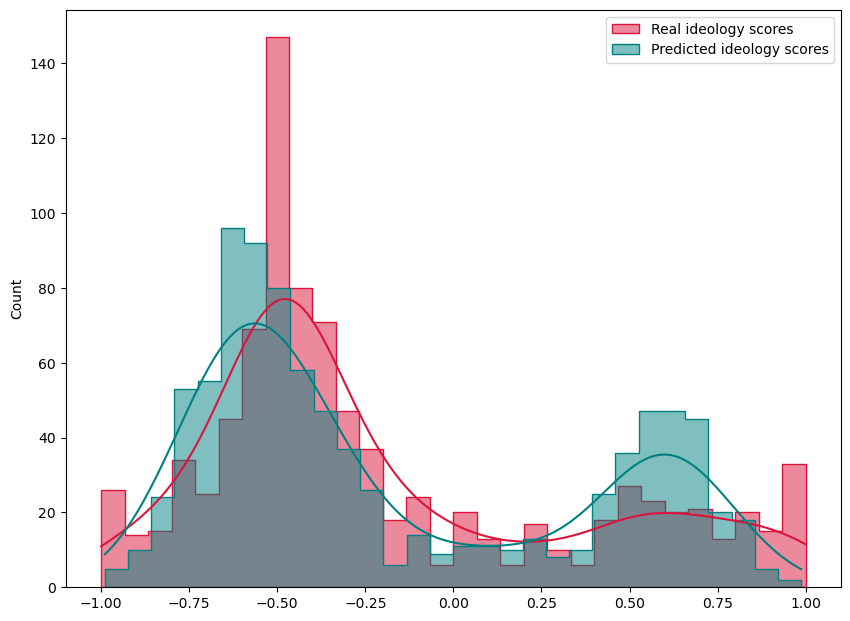

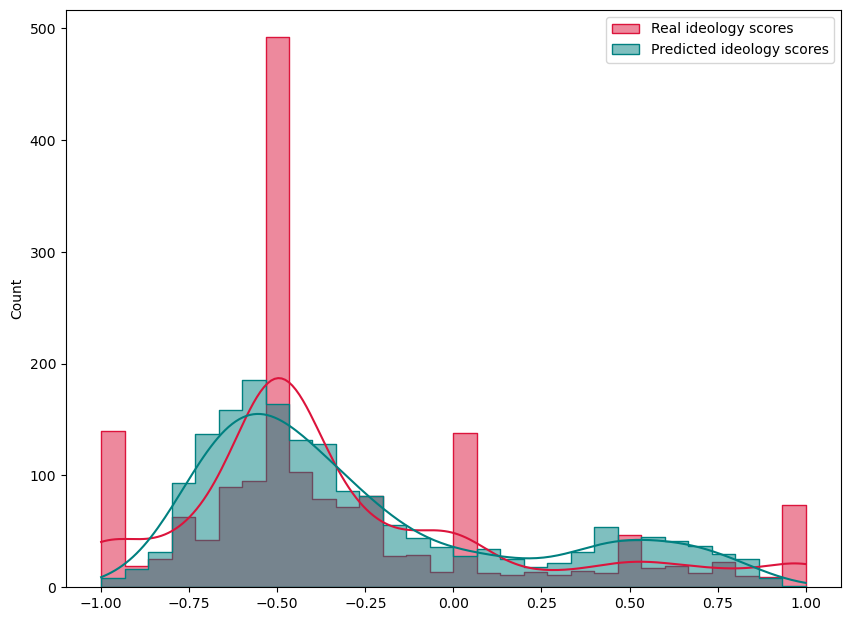

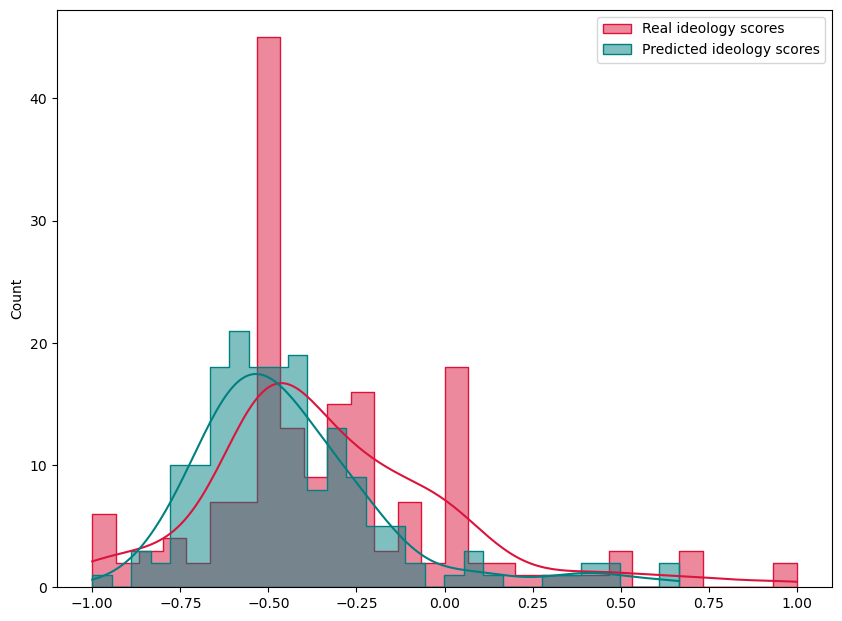

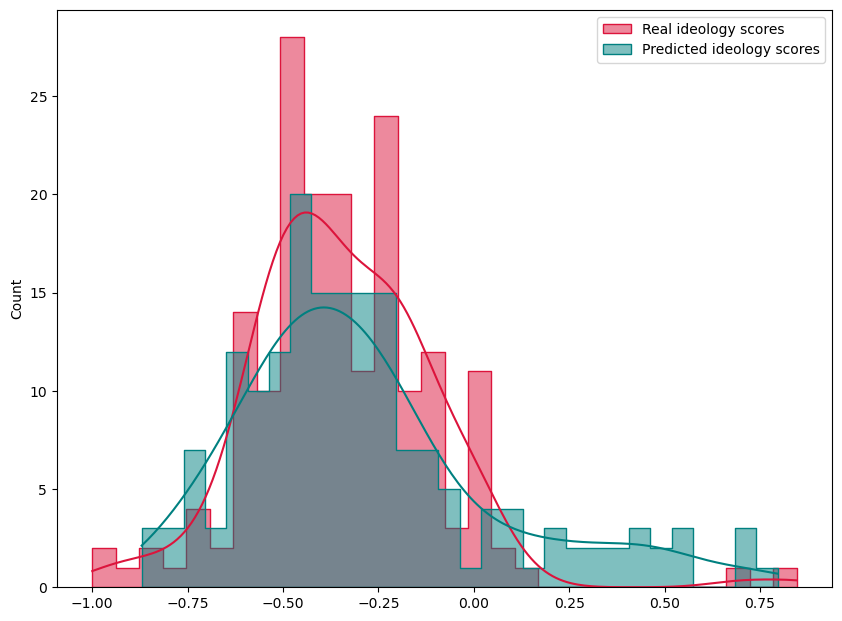

In [9]:
experiments = []

for ds in datasets:
    item = {}
    item["dataset"] = ds

    G, users_embeddings, labels, allsides_scores, node_id_map = get_data(f"data/{ds}/")

    train_allsides = select_10_percent(allsides_scores)
    test_allsides = {k: v for k, v in allsides_scores.items() if k not in train_allsides}
    real = list(test_allsides.values())

    # My method
    user_emb = EchoGAE_algorithm(G, user_embeddings= users_embeddings, show_progress=False, hidden_channels = 20, out_channels=10, epochs=300)

    all_ideologies = ideology_detection(user_emb)

    pred = all_ideologies[list(test_allsides.keys())]

    
    my_mae = min(mae(real, pred), mae(real, -1.0 * pred))
    my_mse = min(mse(real, pred), mse(real, -1.0 * pred))

    item["mae"] = my_mae
    item["mse"] = my_mse

    print(f"MAE: {my_mae:.3f}", end=" -- ")
    print(f"MSE: {my_mse:.3f}")

    # Plot
    if mae(real, pred) <= mae(real, -1.0 * pred):
        plot_ideology(real, pred)
    else:
        plot_ideology(real, -1.0 * pred)

    experiments.append(item)

In [10]:
import pandas as pd
df_idol = pd.DataFrame(experiments)
df_idol

,dataset,mae,mse
0,gun,0.262113,0.114865
1,abortion,0.315146,0.166853
2,super_bowl,0.339347,0.207544
3,sxsw,0.282764,0.139570
